<a href="https://colab.research.google.com/github/n-jagadeep/Image_captioning_Using_Vision_Captioning/blob/main/Image_Captioning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#ECE-GY 6953 - Deep Learning
#Image Captioning using Vision Transformer

#### Nagharjun M (nm4074)
#### Rakshana BS (rb5118)
#### Abirami S (as16288)

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


###Importing the required libraries

In [2]:
from torchvision.models import vit_b_16
import torchvision
import torch
import torch.nn as nn
from torchvision import transforms
import os
import json
import string
from typing import Counter
import PIL
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import transforms
from torch.nn import TransformerDecoderLayer, TransformerDecoder
import torch.nn.functional as F
import time
import nltk
from nltk.translate.bleu_score import corpus_bleu
import tqdm
from tqdm import tqdm
from torchvision.models.feature_extraction import create_feature_extractor
from torchvision import models
from PIL import Image
import urllib.request
from six.moves import urllib
import numpy as np

###Downloading the Dataset

In [3]:
!wget -q https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_Dataset.zip
!wget -q https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_text.zip
!unzip -qq Flickr8k_Dataset.zip
!unzip -qq Flickr8k_text.zip
!rm Flickr8k_Dataset.zip Flickr8k_text.zip

###Downloading Glove Embeddings

In [4]:
!cp "/content/drive/MyDrive/glove.6B.100d.txt.zip" "/content/"
!unzip -q "/content/glove.6B.100d.txt.zip" -d "/content/glove_embeddings/"
!rm glove.6B.100d.txt.zip

###Defining a function to predict caption given an image

In [5]:
def greedy_decoding(model, img_features_batched, sos_id, eos_id, pad_id, idx2word, max_len, device):
    batch_size = img_features_batched.size(0)

    # Define the initial state of decoder input
    x_words = torch.Tensor([sos_id] + [pad_id] * (max_len - 1)).to(device).long()
    x_words = x_words.repeat(batch_size, 1)
    padd_mask = torch.Tensor([True] * max_len).to(device).bool()
    padd_mask = padd_mask.repeat(batch_size, 1)

    # Is each image from the batch decoded
    is_decoded = [False] * batch_size
    generated_captions = []
    for _ in range(batch_size):
        generated_captions.append([])

    for i in range(max_len - 1):
        # Update the padding masks
        padd_mask[:, i] = False

        # Get the model prediction for the next word
        y_pred_prob = model(x_words, img_features_batched, padd_mask)
        # Extract the prediction from the specific (next word) position of the target sequence
        y_pred_prob = y_pred_prob[torch.arange(batch_size), [i] * batch_size].clone()
        # Extract the most probable word
        y_pred = y_pred_prob.argmax(-1)

        for batch_idx in range(batch_size):
            if is_decoded[batch_idx]:
                continue
            # Add the generated word to the caption
            generated_captions[batch_idx].append(idx2word[str(y_pred[batch_idx].item())])
            if y_pred[batch_idx] == eos_id:
                # Caption has been fully generated for this image
                is_decoded[batch_idx] = True

        if np.all(is_decoded):
            break

        if i < (max_len - 1):   # We haven't reached maximum number of decoding steps
            # Update the input tokens for the next iteration
            x_words[torch.arange(batch_size), [i+1] * batch_size] = y_pred.view(-1)

    # Complete the caption for images which haven't been fully decoded
    for batch_idx in range(batch_size):
        if not is_decoded[batch_idx]:
            generated_captions[batch_idx].append(idx2word[str(eos_id)])

    # Clean the EOS symbol
    for caption in generated_captions:
        caption.remove("<end>")

    return generated_captions

###Defining functions to create masks for the decoder and model saving

In [6]:
def set_up_causal_mask(seq_len, device):
    mask = (torch.triu(torch.ones(seq_len, seq_len)) == 1).transpose(0, 1)
    mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0)).to(device)
    mask.requires_grad = False
    return mask


def log_gradient_norm(model, step, mode, norm_type=2):
    total_norm = 0
    for p in model.parameters():
        if p.requires_grad:
            param_norm = p.grad.data.norm(norm_type)
            total_norm += param_norm.item() ** 2
    total_norm = total_norm ** (1. / 2)


def save_checkpoint(model, optimizer, start_time, epoch):
    """Saves specified model checkpoint."""
    target_dir = os.path.join("/content/checkpoints", str(start_time))
    os.makedirs(target_dir, exist_ok=True)
    # Save model weights
    save_path_model = os.path.join(target_dir, f"model_{epoch}.pth")
    save_path_optimizer = os.path.join(target_dir, f"optimizer_{epoch}.pth")
    torch.save(model.state_dict(), save_path_model)
    torch.save(optimizer.state_dict(), save_path_optimizer)
    print("Model saved.")

###Preprocessing the text in the dataset

In [7]:
def preprocess_caption(caption):
    """Performs caption preprocessing"""
    punct_table = str.maketrans("", "", string.punctuation)
    # Extract separate tokens
    caption = caption.split()
    # Make tokens lowercase
    caption = [word.lower() for word in caption]
    # Remove punctuation
    caption = [word.translate(punct_table) for word in caption]
    # Remove trailing "'s" or "a"
    caption = [word for word in caption if len(word) > 1]
    # Remove tokens which contain number
    caption = [word for word in caption if word.isalpha()]
    return " ".join(caption)

In [8]:
def clean_captions(id2annotation):
    image2caption_clean = id2annotation.copy()
    for image_id, captions in id2annotation.items():
        for i in range(len(captions)):
            caption = captions[i]
            # Preprocess caption
            clean_caption = preprocess_caption(caption)
            # Save the cleaned caption
            image2caption_clean[image_id][i] =  clean_caption

    return image2caption_clean

In [9]:
def create_vocab(image2caption):
    # Vocabulary dictionary
    word2idx = {"<pad>": 0, "<start>": 1, "<end>": 2, "<unk>": 3}
    # All possible words in the token
    words = set()
    # Extract all tokens from the image captions
    for captions in image2caption.values():
        current_words = [word for caption in captions for word in caption.split()]
        words.update(current_words)

    starting_len = len(word2idx)
    words = list(words)
    word2idx.update({word: (idx + starting_len) for idx, word in enumerate(words)})

    return word2idx

In [10]:
def extract_embeddings(vocab):
    np.random.seed(2021)
    # embeddings_config = config["embeddings"]
    save_path_emb = '/content/embeddings.txt'
    embedding_dim = 100

    punct_table = str.maketrans("", "", string.punctuation)

    # Used for finding the embedding vector for each token
    vectors = []
    new_vocab = {"<pad>": 0, "<start>": 1, "<end>": 2, "<unk>": 3}
    # Counter used for determining the mapping from word to index
    i = len(new_vocab)

    embedding_file_name = "glove.6B.{}d.txt".format(embedding_dim)
    embeddings_path = os.path.join("glove_embeddings", embedding_file_name)
    # embeddings_path = os.path.join(embedding_file_name)
    with open(embeddings_path, "rb") as f:
        for line in f:
            line = line.decode().split()
            # Extract and pre-process the token
            word = line[0]
            word = word.strip().lower()
            # Remove punctuation
            word = word.translate(punct_table)
            if word in vocab and word not in new_vocab:
                # Save embedding only for words present in the vocab
                embedding_vec = np.array(line[1:], dtype="float")
                vectors += [embedding_vec]
                new_vocab[word] = i
                i += 1

    # Save vocabulary to a file
    with open('/content/word2idx.json', "w", encoding="utf8") as f:
        json.dump(new_vocab, f)

    vectors = np.array(vectors)
    # Embedding vector for tokens used for padding the input sequence
    pad_embedding = np.zeros((embedding_dim,))
    # Embedding vector for start of the sequence
    sos_embedding = np.random.normal(size=(embedding_dim,))
    # Embedding vector for end of the sequence
    eos_embedding = np.random.normal(size=(embedding_dim,))
    # Embedding vector for unknown token
    unk_embedding =  np.random.normal(size=(embedding_dim,))

    # Sanity check: we can't have duplicate embeddings
    assert not np.allclose(sos_embedding, eos_embedding), "SOS and EOS embeddings are too close!"
    for emb_vec in vectors:
        assert not np.allclose(sos_embedding, emb_vec), "SOS embedding is too close to other embedding!"
        assert not np.allclose(eos_embedding, emb_vec), "EOS embedding is too close to other embedding!"

    vectors = np.vstack([pad_embedding, sos_embedding, eos_embedding, unk_embedding, vectors])
    # Save extracted embeddings
    np.savetxt(save_path_emb, vectors)

    print("\nExtracted GloVe embeddings for all tokens in the training set.")
    print("Embedding vectors size:", embedding_dim)
    print("Vocab size:", len(new_vocab))

In [11]:
def save_captions(image2caption, subset_imgs, save_path):
    captions = []
    for image_name in subset_imgs:
        image_id = os.path.splitext(image_name)[0]
        if image_id in image2caption:
            for caption in image2caption[image_id]:
                captions.append("{} {}\n".format(image_name, caption))

    # Save extracted captions
    with open(save_path, "w") as f:
        f.writelines(captions)

In [12]:
def split_dataset(image2caption, split_images_paths, save_paths):
    for load_path, save_path in zip(split_images_paths, save_paths):
        # Load names of images which belong to current subset
        with open(load_path, "r") as f:
            subset_imgs = [fname.replace("\n", "") for fname in f.readlines()]
        # Save processed captions for those images in a separate file
        save_captions(image2caption, subset_imgs, save_path)

In [13]:
def load_captions(data):
    image2caption = dict()
    for sample in data.split("\n"):
        tokens = sample.split()
        if len(sample) < 2:
            # Image has no description: Invalid data row
            continue
		# First token is image id, remaining ones correspond to the caption
        image_name, image_caption = tokens[0], tokens[1:]

        image_id = image_name.split(".")[0]
        # Recreate the description
        image_caption = " ".join(image_caption)

        if image_id not in image2caption:
            image2caption[image_id] = list()
        # Save the description
        image2caption[image_id].append(image_caption)

    return image2caption

In [14]:
# Load and clean the loaded captions
dataset_path = '/content/Flickr8k.token.txt'
with open(dataset_path, "r") as f:
    data = f.read()

image2caption = load_captions(data)
image2caption = clean_captions(image2caption)

# Create and save dataset corpus vocabulary
vocab = create_vocab(image2caption)
# Extract GloVe embeddings for tokens present in the training set vocab
extract_embeddings(vocab)

# Save info regarding the dataset split elements
split_images_paths = ['/content/Flickr_8k.trainImages.txt', '/content/Flickr_8k.devImages.txt', '/content/Flickr_8k.testImages.txt']
split_save_paths = ['/content/train.txt', '/content/validation.txt', '/content/test.txt']
split_dataset(image2caption, split_images_paths, split_save_paths)


Extracted GloVe embeddings for all tokens in the training set.
Embedding vectors size: 100
Vocab size: 7890


###Initializing the dataset class

In [15]:
class Flickr8KDataset(Dataset):
    def __init__(self, path, training=True):
        with open(path, "r") as f:
            self._data = [line.replace("\n", "") for line in f.readlines()]

        self._training = training

        # Create inference data
        self._inference_captions = self._group_captions(self._data)

        # Load the vocabulary mappings
        with open("/content/word2idx.json", "r", encoding="utf8") as f:
            self._word2idx = json.load(f)
        self._idx2word = {str(idx): word for word, idx in self._word2idx.items()}

        # Auxiliary token indices
        self._start_idx = 1
        self._end_idx = 2
        self._pad_idx = 0
        self._UNK_idx = 3
        # Auxiliary token marks
        self._START_token = "<start>"
        self._END_token = "<end>"
        self._PAD_token = "<pad>"
        self._UNK_token = "<unk>"

        self._max_len = 64

        # Transformation to apply to each image
        self._image_specs = {
            "image_dir": {
                "train": "/content/Flicker8k_Dataset",
                "validation": "/content/Flicker8k_Dataset",
                "test": "/content/Flicker8k_Dataset"
              },
            "img_feature_channels": 2048,
            "image_size": 224
        }
        self._image_transform = self._construct_image_transform(self._image_specs["image_size"])

        # Create paths to image files belonging to the subset
        subset = "train" if training else "validation"
        self.image_dir = self._image_specs["image_dir"][subset]

        # Create (X, Y) pairs
        self._data = self._create_input_label_mappings(self._data)

        self._dataset_size = len(self._data) if self._training else 0

    def _construct_image_transform(self, image_size):
        # ImageNet normalization statistics
        normalize = transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
        )
        preprocessing = transforms.Compose([
            transforms.Resize(224),
            transforms.CenterCrop(image_size),
            transforms.ToTensor(),
            normalize,
        ])

        return preprocessing

    def _load_and_process_images(self, image_dir, image_names):
        image_paths = [os.path.join(image_dir, fname) for fname in image_names]
        # Load images
        images_raw = [Image.open(path) for path in image_paths]
        # Adapt the images to CNN trained on ImageNet { PIL -> Tensor }
        image_tensors = [self._image_transform(img) for img in images_raw]

        images_processed = {img_name: img_tensor for img_name, img_tensor in zip(image_names, image_tensors)}
        return images_processed

    def _group_captions(self, data):
        grouped_captions = {}

        for line in data:
            caption_data = line.split()
            img_name, img_caption = caption_data[0].split("#")[0], caption_data[1:]
            if img_name not in grouped_captions:
                # We came across the first caption for this particular image
                grouped_captions[img_name] = []

            grouped_captions[img_name].append(img_caption)

        return grouped_captions

    def _create_input_label_mappings(self, data):
        processed_data = []
        for line in data:
            tokens = line.split()
            # Separate image name from the label tokens
            img_name, caption_words = tokens[0].split("#")[0], tokens[1:]
            # Construct (X, Y) pair
            pair = (img_name, caption_words)
            processed_data.append(pair)

        return processed_data

    def _load_and_prepare_image(self, image_name):
        image_path = os.path.join(self.image_dir, image_name)
        img_pil = Image.open(image_path).convert("RGB")
        image_tensor = self._image_transform(img_pil)
        return image_tensor

    def inference_batch(self, batch_size):
        caption_data_items = list(self._inference_captions.items())
        # random.shuffle(caption_data_items)

        num_batches = len(caption_data_items) // batch_size
        for idx in range(num_batches):
            caption_samples = caption_data_items[idx * batch_size: (idx + 1) * batch_size]
            batch_imgs = []
            batch_captions = []

            # Increase index for the next batch
            idx += batch_size

            # Create a mini batch data
            for image_name, captions in caption_samples:
                batch_captions.append(captions)
                batch_imgs.append(self._load_and_prepare_image(image_name))

            # Batch image tensors
            batch_imgs = torch.stack(batch_imgs, dim=0)
            if batch_size == 1:
                batch_imgs = batch_imgs.unsqueeze(0)

            yield batch_imgs, batch_captions

    def __len__(self):
        return self._dataset_size

    def __getitem__(self, index):
        # Extract the caption data
        image_id, tokens = self._data[index]

        # Load and preprocess image
        image_tensor = self._load_and_prepare_image(image_id)

        # Pad the token and label sequences
        tokens = tokens[:self._max_len]

        tokens = [token.strip().lower() for token in tokens]
        tokens = [self._START_token] + tokens + [self._END_token]
        # Extract input and target output
        input_tokens = tokens[:-1].copy()
        tgt_tokens = tokens[1:].copy()

        # Number of words in the input token
        sample_size = len(input_tokens)
        padding_size = self._max_len - sample_size

        if padding_size > 0:
            padding_vec = [self._PAD_token for _ in range(padding_size)]
            input_tokens += padding_vec.copy()
            tgt_tokens += padding_vec.copy()

        # Apply the vocabulary mapping to the input tokens
        input_tokens = [self._word2idx.get(token, self._UNK_idx) for token in input_tokens]
        tgt_tokens = [self._word2idx.get(token, self._UNK_idx) for token in tgt_tokens]

        input_tokens = torch.Tensor(input_tokens).long()
        tgt_tokens = torch.Tensor(tgt_tokens).long()

        # Index from which to extract the model prediction
        # Define the padding masks
        tgt_padding_mask = torch.ones([self._max_len, ])
        tgt_padding_mask[:sample_size] = 0.0
        tgt_padding_mask = tgt_padding_mask.bool()

        return image_tensor, input_tokens, tgt_tokens, tgt_padding_mask

###Vision Transformer Encoder

In [16]:
class Encoder(nn.Module):
  def __init__(self, output_size):
    super().__init__()
    self.vit = create_feature_extractor(vit_b_16(weights='IMAGENET1K_V1'), return_nodes=['getitem_5'])
    self.output_size = output_size
    self.linear = nn.Linear(768, self.output_size)

  def forward(self, x):
    x = self.vit(x)['getitem_5']
    x = self.linear(x)
    return x


In [17]:
class ResidualBlock(nn.Module):
    """Represents 1D version of the residual block: https://arxiv.org/abs/1512.03385"""

    def __init__(self, input_dim):
        """Initializes the module."""
        super(ResidualBlock, self).__init__()
        self.block = nn.Sequential(
            nn.Linear(input_dim, input_dim),
            nn.LeakyReLU(),
            nn.Linear(input_dim, input_dim),
        )

    def forward(self, x):
        """Performs forward pass of the module."""
        skip_connection = x
        x = self.block(x)
        x = skip_connection + x
        return x

###Transformer Decoder

In [18]:
class CaptionDecoder(nn.Module):
    """Decoder for image captions.

    Generates prediction for next caption word given the prviously
    generated word and image features extracted from CNN.
    """

    def __init__(self):
        """Initializes the model."""
        super(CaptionDecoder, self).__init__()
        model_config = {
            "decoder_layers": 6,
            "d_model": 512,
            "ff_dim": 1024,
            "attention_heads": 16,
            "dropout": 0.5
        }
        decoder_layers = model_config["decoder_layers"]
        attention_heads = model_config["attention_heads"]
        d_model = model_config["d_model"]
        ff_dim = model_config["ff_dim"]
        dropout = model_config["dropout"]

        embedding_dim = 100
        vocab_size = 7890
        img_feature_channels = 2048

        # Load pretrained word embeddings
        word_embeddings = torch.Tensor(np.loadtxt('/content/embeddings.txt'))
        self.embedding_layer = nn.Embedding.from_pretrained(
            word_embeddings,
            freeze=True,
            padding_idx=0
        )

        self.entry_mapping_words = nn.Linear(embedding_dim, d_model)
        self.entry_mapping_img = nn.Linear(img_feature_channels, d_model)

        self.res_block = ResidualBlock(d_model)

        self.positional_encodings = PositionalEncodings(64, d_model, dropout)
        transformer_decoder_layer = TransformerDecoderLayer(
            d_model=d_model,
            nhead=attention_heads,
            dim_feedforward=ff_dim,
            dropout=dropout
        )
        self.decoder = TransformerDecoder(transformer_decoder_layer, decoder_layers)
        self.classifier = nn.Linear(d_model, vocab_size)

    def forward(self, x, image_features, tgt_padding_mask=None, tgt_mask=None):
        """Performs forward pass of the module."""
        # Adapt the dimensionality of the features for image patches
        image_features = self.entry_mapping_img(image_features)
        image_features = image_features.permute(1, 0, 2)
        image_features = F.leaky_relu(image_features)

        # Entry mapping for word tokens
        x = self.embedding_layer(x)
        x = self.entry_mapping_words(x)
        x = F.leaky_relu(x)

        x = self.res_block(x)
        x = F.leaky_relu(x)

        x = self.positional_encodings(x)

        # Get output from the decoder
        x = x.permute(1, 0, 2)
        x = self.decoder(
            tgt=x,
            memory=image_features,
            tgt_key_padding_mask=tgt_padding_mask,
            tgt_mask=tgt_mask
        )
        x = x.permute(1, 0, 2)

        x = self.classifier(x)
        return x

class PositionalEncodings(nn.Module):
    """Attention is All You Need positional encoding layer"""

    def __init__(self, seq_len, d_model, p_dropout):
        """Initializes the layer."""
        super(PositionalEncodings, self).__init__()
        token_positions = torch.arange(start=0, end=seq_len).view(-1, 1)
        dim_positions = torch.arange(start=0, end=d_model).view(1, -1)
        angles = token_positions / (10000 ** ((2 * dim_positions) / d_model))

        encodings = torch.zeros(1, seq_len, d_model)
        encodings[0, :, ::2] = torch.cos(angles[:, ::2])
        encodings[0, :, 1::2] = torch.sin(angles[:, 1::2])
        encodings.requires_grad = False
        self.register_buffer("positional_encodings", encodings)

        self.dropout = nn.Dropout(p_dropout)

    def forward(self, x):
        """Performs forward pass of the module."""
        x = x + self.positional_encodings
        x = self.dropout(x)
        return x

In [19]:
def evaluate(subset, encoder, decoder, device):
    batch_size = 32
    max_len = 64
    bleu_w = {
        "bleu-1": [1.0],
        "bleu-2": [0.5, 0.5],
        "bleu-3": [0.333, 0.333, 0.333],
        "bleu-4": [0.25, 0.25, 0.25, 0.25]
    }

    # Mapping from vocab index to string representation
    idx2word = subset._idx2word
    # Ids for special tokens
    sos_id = subset._start_idx
    eos_id = subset._end_idx
    pad_id = subset._pad_idx

    references_total = []
    predictions_total = []

    print("Evaluating model.")
    for x_img, y_caption in subset.inference_batch(batch_size):
        x_img = x_img.to(device)

        # Extract image features
        img_features = encoder(x_img)
        img_features = img_features.view(img_features.size(0), img_features.size(1), -1)
        img_features = img_features.permute(0, 2, 1)
        img_features = img_features.detach()

        # Get the caption prediction for each image in the mini-batch
        predictions = greedy_decoding(decoder, img_features, sos_id, eos_id, pad_id, idx2word, max_len, device)
        references_total += y_caption
        predictions_total += predictions

    # Evaluate BLEU score of the generated captions
    bleu_1 = corpus_bleu(references_total, predictions_total, weights=bleu_w["bleu-1"]) * 100
    bleu_2 = corpus_bleu(references_total, predictions_total, weights=bleu_w["bleu-2"]) * 100
    bleu_3 = corpus_bleu(references_total, predictions_total, weights=bleu_w["bleu-3"]) * 100
    bleu_4 = corpus_bleu(references_total, predictions_total, weights=bleu_w["bleu-4"]) * 100
    bleu = [bleu_1, bleu_2, bleu_3, bleu_4]
    return bleu

In [21]:
use_gpu = torch.cuda.is_available()
device = torch.device("cuda" if use_gpu else "cpu")
decoder = CaptionDecoder()
decoder = decoder.to(device)
def train(device):
    torch.manual_seed(2021)
    np.random.seed(2021)

    # Define dataloader hyper-parameters
    train_hyperparams = {
        "batch_size": 32,
        "shuffle": True,
        "num_workers": 1,
        "drop_last": True
    }

    # Create dataloaders
    train_set = Flickr8KDataset("/content/train.txt", training=True)
    valid_set = Flickr8KDataset("/content/validation.txt", training=False)
    train_loader = DataLoader(train_set, **train_hyperparams)

    encoder = Encoder(2048)
    encoder = encoder.to(device)
    # Freeze encoder layers
    for param in encoder.parameters():
        param.requires_grad = False
    encoder.eval()
    decoder.train()

    # Set up causal mask for transformer decoder
    causal_mask = set_up_causal_mask(64, device)

    # Load training configuration
    train_config = {
        "num_of_epochs": 5,
        "warmup_steps": 2811,
        "l2_penalty": 0.5,
        # "learning_rate": 0.000008,
        "learning_rate": 0.00001,
        "gradient_clipping": 2.0,
        "eval_period": 1
    }
    learning_rate = train_config["learning_rate"]

    # Prepare the model optimizer
    optimizer = torch.optim.AdamW(
        decoder.parameters(),
        lr=train_config["learning_rate"],
        weight_decay=train_config["l2_penalty"]
    )

    # Loss function
    loss_fcn = nn.CrossEntropyLoss(label_smoothing=0.1)

    start_time = time.strftime("%b-%d_%H-%M-%S")
    train_step = 0
    for epoch in range(train_config["num_of_epochs"]):
        print("Epoch:", epoch)
        decoder.train()
        nb_tr_steps = 0
        tr_loss = 0

        with tqdm(train_loader, unit="batch") as tepoch:
        # for x_img, x_words, y, tgt_padding_mask in tqdm(enumerate(train_loader, 0), position=0, leave=True):
          for x_img, x_words, y, tgt_padding_mask in tepoch:
              optimizer.zero_grad()
              train_step += 1

              # Move the used tensors to defined device
              x_img, x_words = x_img.to(device), x_words.to(device)
              y = y.to(device)
              tgt_padding_mask = tgt_padding_mask.to(device)

              # Extract image features
              with torch.no_grad():
                  img_features = encoder(x_img)
                  img_features = img_features.view(img_features.size(0), img_features.size(1), -1)
                  img_features = img_features.permute(0, 2, 1)
                  img_features = img_features.detach()

              # Get the prediction of the decoder
              y_pred = decoder(x_words, img_features, tgt_padding_mask, causal_mask)
              tgt_padding_mask = torch.logical_not(tgt_padding_mask)
              y_pred = y_pred[tgt_padding_mask]

              y = y[tgt_padding_mask]
              # print(y_pred.shape)

              # Calculate the loss
              loss = loss_fcn(y_pred, y.long())
              nb_tr_steps += 1
              tr_loss += loss.item()
              avg_loss = tr_loss / nb_tr_steps
              tepoch.set_postfix(loss=avg_loss)

              # Update model weights
              loss.backward()
              # log_gradient_norm(decoder, train_step, "Before")
              torch.nn.utils.clip_grad_norm_(decoder.parameters(), train_config["gradient_clipping"])
              # log_gradient_norm(decoder, train_step, "After")
              optimizer.step()
              # print(loss.item())

              # writer.add_scalar("Train/Step-Loss", loss.item(), train_step)
              # writer.add_scalar("Train/Learning-Rate", learning_rate, train_step)

        # Save the model and optimizer state
        save_checkpoint(decoder, optimizer, start_time, epoch)
        # Evaluate model performance
        if (epoch + 1) % train_config["eval_period"] == 0:
            with torch.no_grad():
                encoder.eval()
                decoder.eval()

                # Evaluate model performance on subsets
                train_bleu = evaluate(train_set, encoder, decoder, device)
                valid_bleu = evaluate(valid_set, encoder, decoder, device)
                print("Epoch: " + str(epoch) + " | train_bleu: " + str(train_bleu) + " | valid_bleu: " + str(valid_bleu))

                decoder.train()

        print()

In [22]:
train(device)

Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth
100%|██████████| 330M/330M [00:02<00:00, 152MB/s]
/usr/local/lib/python3.10/dist-packages/torch/overrides.py:110: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  torch.has_cuda,
/usr/local/lib/python3.10/dist-packages/torch/overrides.py:111: UserWarning: 'has_cudnn' is deprecated, please use 'torch.backends.cudnn.is_available()'
  torch.has_cudnn,
/usr/local/lib/python3.10/dist-packages/torch/overrides.py:117: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  torch.has_mps,
/usr/local/lib/python3.10/dist-packages/torch/overrides.py:118: UserWarning: 'has_mkldnn' is deprecated, please use 'torch.backends.mkldnn.is_available()'
  torch.has_mkldnn,


Epoch: 0


  0%|          | 0/937 [00:00<?, ?batch/s]/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:5076: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(
100%|██████████| 937/937 [07:45<00:00,  2.01batch/s, loss=6.87]


Model saved.
Evaluating model.


/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_

Evaluating model.
Epoch: 0 | train_bleu: [0.6006643922723696, 9.711814202153071e-155, 8.484930559709011e-206, 1.2349080002176717e-231] | valid_bleu: [0.6009753747950448, 9.636180557665456e-155, 8.395444611201136e-206, 1.2201944772366165e-231]

Epoch: 1


100%|██████████| 937/937 [07:58<00:00,  1.96batch/s, loss=6.07]


Model saved.
Evaluating model.
Evaluating model.
Epoch: 1 | train_bleu: [18.542487291996597, 6.276926485637188, 3.977867429138384e-102, 2.2183312369162572e-153] | valid_bleu: [18.732323166723607, 6.1617489966785985, 3.946462739456773e-102, 2.2124358744525326e-153]

Epoch: 2


100%|██████████| 937/937 [07:59<00:00,  1.96batch/s, loss=5.84]


Model saved.
Evaluating model.
Evaluating model.
Epoch: 2 | train_bleu: [5.423130143470976, 2.3948739212816412, 0.6442195713871733, 2.7667293317645798e-77] | valid_bleu: [5.477432274817895, 2.4058563578367003, 0.6459018702551725, 2.772151718394614e-77]

Epoch: 3


100%|██████████| 937/937 [08:00<00:00,  1.95batch/s, loss=5.62]


Model saved.
Evaluating model.
Evaluating model.
Epoch: 3 | train_bleu: [10.773286669813382, 4.726264127630272, 1.3081231565421263, 0.23075803302261355] | valid_bleu: [10.754012954097437, 4.542303031399445, 1.1653687098886563, 4.3174967428241716e-77]

Epoch: 4


100%|██████████| 937/937 [08:00<00:00,  1.95batch/s, loss=5.47]


Model saved.
Evaluating model.
Evaluating model.
Epoch: 4 | train_bleu: [12.47037497473835, 5.816717035805238, 2.0733250849845994, 0.5745620373863861] | valid_bleu: [12.564423501693417, 5.645947911580736, 1.8695025654441426, 0.48057406808641073]



### Test Examples

In [23]:
encoder = Encoder(2048)
with open("/content/word2idx.json", "r", encoding="utf8") as f:
  word2idx = json.load(f)
  idx2word = {str(idx): word for word, idx in word2idx.items()}

In [24]:
def preds(url):
  urllib.request.urlretrieve(
    url,
    "test.png")
  img = Image.open("test.png")
  img = img.resize((224,224))
  transform = transforms.Compose([
      transforms.ToTensor()
  ])
  img_tensor = transform(img)
  img_tensor = img_tensor[None, :]
  img_features = encoder(img_tensor)
  img_features = img_features.view(img_features.size(0), img_features.size(1), -1)
  img_features = img_features.permute(0, 2, 1)
  img_features = img_features.detach()
  img_features = img_features.to(device)
  predictions = greedy_decoding(decoder, img_features, 1, 2, 0, idx2word, 64, device)
  return predictions

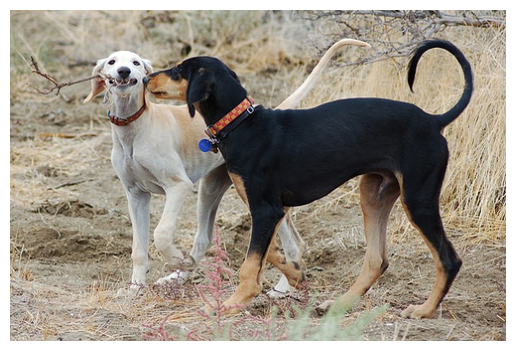

[['two', 'white', 'dog', 'and', 'white', 'and', 'white', 'and', 'white', 'and', 'white', 'and', 'white', 'and', 'white', 'dog', 'and', 'white', 'and', 'white', 'and', 'white', 'and', 'white', 'dog', 'is', 'and', 'white', 'and', 'white', 'and', 'white', 'and', 'white', 'dog', 'is', 'and', 'white', 'and', 'white', 'dog', 'is', 'dog', 'is', 'is', 'and', 'white', 'and', 'white', 'and', 'white', 'dog', 'is', 'and', 'dog', 'is', 'is', 'and', 'white', 'and', 'white', 'dog', 'is']]


In [29]:
import cv2
from matplotlib import pyplot as plt
caption = preds('https://user-images.githubusercontent.com/64778259/238737981-faee9825-aca2-4b83-8b19-5ddcc919bf80.jpg')
img = cv2.imread("test.png")
plt.axis("off")
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()
print(caption)

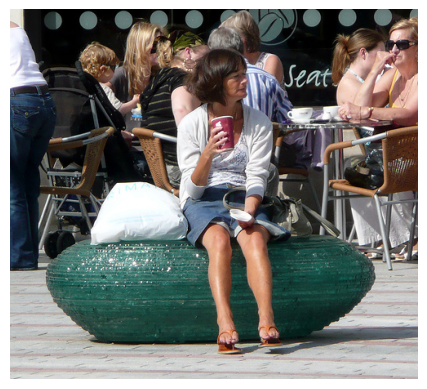

[['man', 'is', 'is', 'white', 'is', 'and', 'red', 'and', 'white', 'is', 'and', 'white', 'and', 'white', 'dog']]


In [30]:
caption = preds('https://user-images.githubusercontent.com/64778259/238737614-c9843ad5-3eaa-4598-a021-9de64f3e9b2f.jpg')
img = cv2.imread("test.png")
plt.axis("off")
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()
print(caption)